In [83]:
from sympy import *
from sympy.abc import r,x,y,z
from sympy import init_printing
from scipy.integrate import quad, nquad
from cubature import cubature
import sympy.printing.llvmjitcode as jit
from timeit import timeit
import matplotlib.pyplot as plt
%matplotlib inline
init_printing()


# Energy of the Hydrogen Atom
The variational principle states a trial wavefunction will have an energy greater than or equal to the ground state energy.
$$\frac{\int \psi H \psi}{ \int \psi^2}  \ge E_0$$

First consider the hydogen atom. Let us use a trial wavefunction that is not the exact ground state.

In [82]:
beta = Symbol('beta')
R_T = exp(-r - beta*r*r)
R_T

The Hamiltonian for this system is
$$-\frac{1}{2} \nabla^2 - \frac{1}{r}$$
The first step is to compute the derivative of the trial wavefunction in spherical coordinates

In [5]:
def del_spherical(e, r):
    """Compute Laplacian for expression e with respect to symbol r.
        Currently works only with radial dependence"""
    t1 = r*r*diff(e, r)
    t2 = diff(t1, r)/(r*r)
    return simplify(t2)

In [6]:
del1 = del_spherical(R_T, r)


Construct $\psi H \psi$

In [7]:
H = -1/2 * R_T * del1  - R_T*R_T/r

In [8]:
simplify(H)

Construct the integral in spherical coordinates  (There should be an additional factor of $4 \pi$, but it will cancel since it occurs in the numerator and denominator)

In [9]:
h1 = simplify(r*r*H)

Substitute a concrete value for $\beta$.

In [72]:
h2 = h1.subs(beta, 0.1)

Perform the integral

In [73]:
num = integrate(h2, (r, 0, oo)).evalf()
num

Also construct and integrate the denominator (the normalization).

In [12]:
norm1 = r*r*R_T*R_T
norm2 = norm1.subs(beta, 0.1)
norm3 = simplify(norm2)

In [55]:
denom = integrate(norm3, (r, 0, oo)).evalf()
simplify(denom).evalf()

In [56]:
E = num/denom
E

And, as expected, energy is greater than the exact ground state energy of -0.5 Hartree.

## Find the minimum energy
Collect all the steps for computing the energy into a single function.   Even though this particular integral could be done symbolicly, use numerical integration instead.

In [76]:
def compute_energy(R_T, beta_val):
    """Energy given a value for beta"""
    
    # Normalization integrand (denominator)
    norm1 = r*r*R_T*R_T
    norm2 = norm1.subs(beta, beta_val)
    norm3 = simplify(norm2)

    # Integrand for the numerator
    del1 = del_spherical(R_T, r)
    # Construct psi * H * psi
    H = -1/2 * R_T * del1  - R_T*R_T/r
    h1 = simplify(r*r*H)
    h2 = h1.subs(beta, beta_val)
    
    lim = 20.0
    
    denom_func = lambdify([r], norm3)
    denom_res = quad(denom_func, 0.0, lim)
    
    num_func = lambdify([r], h2)
    num_res = quad(num_func, 0.0, lim)

    e = num_res[0]/denom_res[0]

    return e
   

Now the energy can be computed vs. $\beta$, and we can find the minimum energy.  In this case, the minimum occurs at $\beta = 0$, which we know is the exact wavefunction for the hydrogen atom.

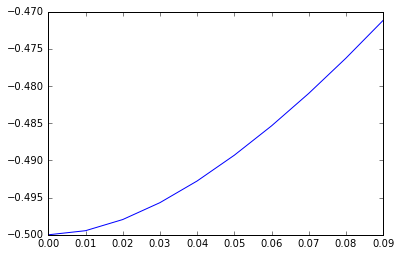

In [77]:
energies = []
betas = []
for i in range(10):
    beta_val = i*.01
    e = compute_energy(R_T, beta_val)
    betas.append(beta_val)
    energies.append(e)

plt.plot(betas, energies)

# Integration Performance

Anticipating the need to handle larger systems, let us look at the performance of the integration and ways it might be improved.  First, using a Python callback:

In [46]:
norm1 = r*r*R_T*R_T
norm2 = norm1.subs(beta, 0.1)
norm3 = simplify(norm2)

del1 = del_spherical(R_T, r)
H = -1/2 * R_T * del1  - R_T*R_T/r
h1 = simplify(r*r*H)
h2 = h1.subs(beta, beta_val)

lim = 20.0


In [47]:
denom_func = lambdify([r], norm3)
num_func = lambdify([r], h2)

def py_quad():
    denom_res = quad(denom_func, 0.0, lim)
    num_res = quad(num_func, 0.0, lim)

time = timeit(stmt=py_quad, number=1000)
print('Integration time with Python callback = %0.3f ms'%time)


Integration time with Python callback = 0.140 ms


The `quad` function can also accept a natively compiled callback function.  Use that and compare.

In [48]:
jit_denom_func = jit.llvm_callable([r], norm3, callback_type='scipy.integrate')
jit_num_func = jit.llvm_callable([r], h2, callback_type='scipy.integrate')

def jit_quad():
    denom_res = quad(jit_denom_func, 0.0, lim)
    num_res = quad(jit_num_func, 0.0, lim)

time = timeit(stmt=jit_quad, number=1000)
print('Integration time with JIT callback = %0.3f ms'%time)


Integration time with JIT callback = 0.021 ms


Almost 10x performance improvement using the JIT callback.

## 3-D Integration

What if the integral were not spherically symmetric - perform the full 3-D integral.

Set up problem:

In [ ]:
norm1 = R_T*R_T
norm2 = norm1.subs(beta, 0.1)
norm3 = norm2.subs(r, sqrt(x*x + y*y + z*z))
norm4 = simplify(norm3)

del1 = del_spherical(R_T, r)
H = -1/2 * R_T * del1  - R_T*R_T/r
h1 = simplify(H)
h2 = h1.subs(beta, 0.1)
h3 = h2.subs(r, sqrt(x*x + y*y + z*z))

lim = 20.0
lims = [[-lim, lim]]*3

### Scipy nquad with Python callback

In [49]:
denom_func = lambdify([x, y, z], norm4)
num_func = lambdify([x,y,z], h3)

def py_quad():
    acc = {'epsabs':1e-6, 'epsrel':1e-6}
    denom_res = nquad(denom_func, lims, opts=acc)
    num_res = nquad(num_func, lims, opts=acc)
    print('E = ',num_res[0]/denom_res[0])

time = timeit(stmt=py_quad, number=1)
print('Integration time with Python callback = %0.3f s'%time)

E =  -0.465803452019705
Integration time with Python callback = 9.090 s


### Scipy nquad with JIT callback

In [50]:
jit_denom_func = jit.llvm_callable([x,y,z], norm4, callback_type='scipy.integrate')
jit_num_func = jit.llvm_callable([x,y,z], h3, callback_type='scipy.integrate')

def jit_quad():
    acc = {'epsabs':1e-6, 'epsrel':1e-6}
    denom_res = nquad(jit_denom_func, lims, opts=acc)
    num_res = nquad(jit_num_func, lims, opts=acc)
    print('E = ',num_res[0]/denom_res[0])

time = timeit(stmt=jit_quad, number=1)
print('Integration time with JIT callback = %0.3f s'%time)

E =  -0.4658034520197049
Integration time with JIT callback = 0.723 s


The `nquad` method uses iterated 1-D integrals.  With a compiled callback, there is quite a bit of time spent in the Python glue that manages those calls.   A better solution is to use an integrator designed for multi-dimensional integration.

For this we use the [Python interface](https://github.com/saullocastro/cubature) to the [Cubature](http://ab-initio.mit.edu/wiki/index.php/Cubature) package.

### Cubature with JIT callback

In [59]:
cub_denom_func = jit.llvm_callable([x,y,z], norm4, callback_type='cubature')
cub_num_func = jit.llvm_callable([x,y,z], h3, callback_type='cubature')

lim_min = [l[0] for l in lims]
lim_max = [l[1] for l in lims]
def cubature_quad():
    epsabs = 1e-6
    epsrel = 1e-6
    denom_res = cubature(cub_denom_func, ndim=3, fdim=1, xmin=lim_min, xmax=lim_max, abserr=epsabs, relerr=epsrel)
    num_res = cubature(cub_num_func, ndim=3, fdim=1, xmin=lim_min, xmax=lim_max, abserr=epsabs, relerr=epsrel)
    print('E = ',num_res[0]/denom_res[0])

time = timeit(stmt=cubature_quad, number=1)
print('Integration time with cubature and JIT callback = %0.3f s'%time)

E =  [-0.46580346]
Integration time with cubature and JIT callback = 0.057 s


Another 10x performance improvement when moving to the Cubature package.

This demonstrates some of the technical machinery for a simple example where we know the actual answer.   Time to move onto a system where an exact (analytic) answer is not known - the helium atom.